# Titre projet

Our second strategy builds on the allocation-focused regime framework introduced by Yu, Mulvey, and Nie (2025). In this approach, regimes are not defined by broad macroeconomic states, but directly by the relative performance of investment strategies. A Jump Model (JM) identifies periods in which a factor persistently outperforms or underperforms its benchmark, and an XGBoost classifier forecasts future regimes using enriched market and macro features. All hyperparameters—including the jump penalty λ—are selected in a fully performance-driven manner by maximizing the validation Sharpe ratio.

We adopt this philosophy but adapt it to a monthly Fama–French setting. Regime identification is kept intentionally simple (EWMA features only), while regime forecasting leverages a richer macro feature set (z-scores, polynomial terms, EMAs, slopes). We apply the framework to Momentum, Value, and Size, then combine the resulting strategies into a multi-factor portfolio.

Before settling on this methodology, we explored macro regime clustering (k-means, GMM) on FRED-MD data. Although these methods captured macroeconomic conditions, they offered weak and unstable links to factor performance. In contrast, the allocation-focused approach directly targets the quantity that matters for portfolio construction—the relative performance of factors—and proved more robust, interpretable, and effective out-of-sample.

In [1]:
from fredapi import Fred

from io import BytesIO

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

import numpy as np
from numpy.linalg import svd

import pandas as pd
from pathlib import Path
from PIL import Image

import re
import requests
import random

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, log_loss
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist
from scipy.special import expit

from typing import Optional, Dict, Tuple
import os

import ruptures as rpt
from skfin.datasets_ import load_kf_returns
from skfin.mv_estimators import Mbj
from skfin.plot import line, heatmap
from itertools import product
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from skfin.metrics import drawdown

# from skfin.dataloaders.cache import CacheManager


## 1. Data preprocessing

### FRED-MD dataset

In [2]:
url_data = "https://raw.githubusercontent.com/lxsd111/ML_PM/main/nbs/data/2025-09-MD.csv"
fred = pd.read_csv(url_data, index_col=0)

# --- Separate transformation "tcodes" (first row) and actual data (remaining rows) ---
fred_data = fred.iloc[1:,:].copy()
fred_code = fred.iloc[0,:].copy()

# --- Convert index to datetime ---
fred_data.index = pd.to_datetime(fred_data.index, infer_datetime_format=True)
print(fred_data.info())

# --- Drop variables with too many missing values ---
cols_to_drop = ["ACOGNO", "TWEXAFEGSMTHx", "UMCSENTx", "ANDENOx"]
fred_data = fred_data.drop(columns=cols_to_drop, errors="ignore").copy()

# --- Function: count consecutive NaN values at the end of a series ---
def trailing_nans(s: pd.Series) -> int:
    """Count the number of consecutive NaN values at the end of a Series."""
    if not s.isna().any():
        return 0
    return int(np.argmax(~s[::-1].isna().values)) if s.isna().any() else 0

# --- Identify variables with trailing NaNs ---
nan_trails = {col: trailing_nans(fred_data[col]) for col in fred_data.columns}
nan_trails = {k: v for k, v in nan_trails.items() if v > 0}

# --- Shift series forward by 'n' months if they have n trailing NaNs ---
for col, lag in nan_trails.items():
    if lag > 0:
        fred_data[col] = fred_data[col].shift(lag)

# --- Restrict the sample to ensure consistent coverage across variables ---
fred_data = fred_data.loc[fred_data.index >= "1962-05-01"]

print(f"\nFinal dataset size: {fred_data.shape[0]} observations, {fred_data.shape[1]} variables")

# --- Normalize column names to ensure alignment between data and codes ---
fred_data.columns = fred_data.columns.str.upper()

# >>>>> DUPLICATION FEDFUNDS SANS TRANSFORMATION <<<<<
# On crée une seconde colonne FEDFUNCS qui restera en niveau (pas de t-code appliqué)
if "FEDFUNDS" in fred_data.columns:
    fred_data["FEDFUNCS"] = fred_data["FEDFUNDS"]

# fred_code is a single-row DataFrame or a Series with tcodes per column
tcode_map = fred_code.squeeze()                    # to Series if single row
tcode_map.index = tcode_map.index.str.upper()      # align names
tcode_map = pd.to_numeric(tcode_map, errors="coerce")

# --- Container for transformed series ---
df_transformed = pd.DataFrame(index=fred_data.index)

# --- Apply McCracken–Ng tcodes where available; otherwise keep series as is ---
for col in fred_data.columns:
    s = fred_data[col]
    code = tcode_map.get(col, np.nan)  # NaN => no code available

    if pd.isna(code):
        # No transformation code: keep original series (ce sera le cas de FEDFUNCS)
        s_tr = s
    else:
        code = int(code)
        if code == 1:
            s_tr = s
        elif code == 2:
            s_tr = s.diff()
        elif code == 3:
            s_tr = s.diff().diff()
        elif code == 4:
            # Log of levels; guard against non-positive values
            s_tr = s.where(s > 0)
            s_tr = np.log(s_tr)
        elif code == 5:
            # First difference of log (approximate growth rate)
            s_tr = s.where(s > 0)
            s_tr = np.log(s_tr).diff()
        elif code == 6:
            # Second difference of log
            s_tr = s.where(s > 0)
            s_tr = np.log(s_tr).diff().diff()
        else:
            # Δ(x_t / x_{t-1} - 1)
            r = s / s.shift(1) - 1
            s_tr = r.diff()

    df_transformed[col] = s_tr

# List of selected variables
cols_bis = [
    "M2SL",
    "FEDFUNDS",
    "FEDFUNCS",
    "T1YFFM", "T5YFFM", "T10YFFM", "AAAFFM",
    "BAAFFM", "OILPRICEX", "CPIAUCSL",
    "S&P 500", "S&P DIV YIELD", "S&P PE RATIO", "VIXCLSX"
]

# Extract the reduced dataset
df_bis = df_transformed[cols_bis].copy()

# Overview of dimensions and sample rows
print(df_bis.shape)
df_bis.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 800 entries, 1959-01-01 to 2025-08-01
Columns: 126 entries, RPI to VIXCLSx
dtypes: float64(102), int64(24)
memory usage: 793.8 KB
None

Final dataset size: 760 observations, 122 variables
(760, 14)


/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_1658/1465958471.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_transformed[col] = s_tr
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_1658/1465958471.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_transformed[col] = s_tr
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_1658/1465958471.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

,M2SL,FEDFUNDS,FEDFUNCS,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,OILPRICEX,CPIAUCSL,S&P 500,S&P DIV YIELD,S&P PE RATIO,VIXCLSX
sasdate,,,,,,,,,,,,,,
1962-05-01,NaN,NaN,2.36,0.67,1.30,1.51,1.92,2.64,NaN,NaN,NaN,NaN,NaN,NaN
1962-06-01,NaN,0.32,2.68,0.35,0.96,1.23,1.60,2.34,NaN,NaN,-0.124253,0.105335,-0.084937,NaN
1962-07-01,-0.000881,0.03,2.71,0.58,1.09,1.30,1.63,2.34,0.0,0.001324,0.023802,0.252174,-0.133255,19.5715
1962-08-01,0.001400,0.22,2.93,0.27,0.78,1.05,1.42,2.13,0.0,0.001653,0.026844,0.443267,0.010199,15.7942
1962-09-01,0.000250,-0.03,2.90,0.16,0.80,1.08,1.42,2.13,0.0,0.002629,-0.008926,-0.075392,0.016086,18.3148


Each variable in the **FRED-MD** dataset is associated with a *transformation code* (`tcode`), which specifies how the raw series should be transformed before analysis to achieve stationarity and comparability across variables.

The transformation rules, as defined by McCracken and Ng (2016), are as follows:

| Code | Transformation | Description |
|:----:|:------------------------------|:-----------------------------------------------|
| 1 | *No transformation* | Use the level of the series as is |
| 2 | $\Delta x_t$ | First difference of the raw series |
| 3 | $\Delta^2 x_t$ | Second difference of the raw series |
| 4 | $\log(x_t)$ | Natural logarithm of the level |
| 5 | $\Delta \log(x_t)$ | First difference of the logarithm (approximate growth rate) |
| 6 | $\Delta^2 \log(x_t)$ | Second difference of the logarithm |
| 7 | $\Delta \left(\frac{x_t}{x_{t-1}} - 1\right)$ | Change in the growth rate (ratio form) |

These transformations are applied to ensure that most macroeconomic series are **stationary** before being used in empirical models such as factor analysis or forecasting.
Variables marked with an asterisk (*) in the FRED-MD documentation indicate that minor adjustments were made relative to their original FRED source (see McCracken & Ng, *"FRED-MD: A Monthly Database for Macroeconomic Research"*, 2016).


In [4]:
# ============================================================
# 1) COPY — On part de df_bis déjà transformé (FRED-MD tcodes)
# ============================================================
macro = df_bis.copy()

# ==============================
# 2) Z-SCORES (rolling)
# ==============================
ROLL_Z = 12    # 24 mois ~ 2 ans : standard en macro-finance

macro_z = (macro - macro.rolling(ROLL_Z).mean()) / macro.rolling(ROLL_Z).std()
macro_z.columns = [c + "_Z" for c in macro.columns]

# ==============================
# 3) FEATURES POLYNOMIALES
# ==============================
macro_poly2 = macro.pow(2).add_prefix("SQ_")          # x²
macro_poly3 = macro.pow(3).add_prefix("CUBE_")        # x³

# ==============================
# 4) EMA (exponential moving avg)
# ==============================
EMA_SPANS = [2, 3, 6]

macro_ema = pd.DataFrame(index=macro.index)
for span in EMA_SPANS:
    ema_tmp = macro.ewm(span=span, adjust=False).mean()
    ema_tmp.columns = [f"{c}_EMA{span}" for c in macro.columns]
    macro_ema = pd.concat([macro_ema, ema_tmp], axis=1)

# ==============================
# 5) Rolling Volatility & Rolling Slope (linear trend)
# ==============================
ROLL_WINDOW = 12

macro_rollvol = macro.rolling(ROLL_WINDOW).std().add_prefix("VOL_")

# Rolling slope via regression sur rolling window
def rolling_slope(x, window=ROLL_WINDOW):
    idx = np.arange(window)
    coefs = []
    for i in range(window, len(x)+1):
        y = x[i-window:i]
        if y.isna().any():
            coefs.append(np.nan)
            continue
        # slope via OLS closed-form
        beta = np.cov(idx, y)[0,1] / np.var(idx)
        coefs.append(beta)
    return pd.Series([np.nan]*(window-1) + coefs, index=x.index)

macro_slope = pd.DataFrame(index=macro.index)
for c in macro.columns:
    macro_slope[c + "_SLOPE"] = rolling_slope(macro[c])

# ==============================
# 7) Assemblage final sans lookahead
# ==============================
X_macro_enriched = pd.concat([
    macro,
    macro_z,
    macro_poly2,
    macro_ema,
    macro_slope
], axis=1)

# Remplissage propre (uniquement forward-fill)
macro = X_macro_enriched.fillna(method="ffill").dropna()

print("Shape enriched macro :", X_macro_enriched.shape)


Shape enriched macro : (760, 98)


### Fama–French style factors

The factor data are sourced from Kenneth French’s Data Library, which provides long-horizon, research-grade monthly time series widely used in empirical asset pricing. The dataset includes five well-known Fama–French style factors: **SMB**, **HML**, **RMW**, **CMA**, and **MOM**, each representing a distinct compensated source of risk in cross-sectional equity returns. **SMB** (Small Minus Big) captures the size premium by measuring the performance spread between small-cap and large-cap stocks. **HML** (High Minus Low) reflects the value premium by comparing returns of high book-to-market firms to low book-to-market firms. **RMW** (Robust Minus Weak) measures the profitability premium, contrasting firms with strong operating profitability against those with weak profitability. **CMA** (Conservative Minus Aggressive) represents the investment premium based on differences in corporate investment policies. Finally, **MOM** (Momentum) captures the well-documented tendency for stocks with strong past performance to continue outperforming in the near term. Together, these factors form a comprehensive framework for explaining and modeling the cross-section of expected equity returns.


In [5]:
ff = load_kf_returns(filename="F-F_Research_Data_Factors")["Monthly"].copy()
mom = load_kf_returns(filename="F-F_Momentum_Factor")["Monthly"].copy()

ff.index  = pd.to_datetime(ff.index,  format="%Y%m")
mom.index = pd.to_datetime(mom.index, format="%Y%m")
ff.columns  = ff.columns.str.strip()
mom.columns = mom.columns.str.strip()

# Identifier automatiquement la colonne momentum (Mom / MOM / Mom   )
mom_col = [c for c in mom.columns if c.lower().startswith("mom")][0]

# Fusion propre
factors = (
    ff[["Mkt-RF", "SMB", "HML", "RF"]]
    .join(mom.rename(columns={mom_col: "Momentum"})[["Momentum"]], how="inner")
).rename(columns={
    "SMB":  "Size",
    "HML":  "Value",
})

# Convertir en décimal
ret_cols = ["Mkt-RF", "Size", "Value", "RF", "Momentum"]
factors[ret_cols] = factors[ret_cols] / 100

# Marché total = excès + RF
factors["Mkt"] = factors["Mkt-RF"] + factors["RF"]

# Spreads facteur – Mkt
for s in ["Momentum", "Size", "Value"]:
    factors[f"{s}_minus_Mkt"] = factors[s] - factors["Mkt"]

# On garde à partir de 1963
factors = factors[factors.index >= "1963-01-01"].copy()
print("Facteurs FF+MOM :", factors.shape)


Facteurs FF+MOM : (752, 9)


## II. Regime Identification


For each factor, we compute the **active return**:

$$
r_{\text{active}}(t) = r_{\text{factor}}(t) - r_{\text{market}}(t).
$$

To identify persistent performance regimes, we approximate the Jump Model using the
**PELT segmentation algorithm** from the `ruptures` library.
We smooth the active returns using several EWMAs and feed them into PELT.

PELT solves the penalized least-squares segmentation problem:

$$
\min_{\tau_1,\ldots,\tau_K}
\left[
\sum_{k=1}^{K+1}
\sum_{t=\tau_{k-1}+1}^{\tau_k}
\Vert X_t - \mu_k \Vert^2
+
\lambda K
\right].
$$

Each segment $k$ is represented by its mean:

$$
\mu_k =
\frac{1}{\tau_k - \tau_{k-1}}
\sum_{t=\tau_{k-1}+1}^{\tau_k} X_t.
$$

The penalty parameter $ \lambda $ controls regime persistence:
large $ \lambda $ → few, stable regimes;
small $ \lambda $ → many, reactive regimes.

This is mathematically analogous to the original Jump Model of Yu–Mulvey–Nie.


PELT returns unlabeled segments.
We assign each segment an allocation-relevant interpretation based on its mean active return:

$$
\bar{r}_k =
\frac{1}{\tau_k - \tau_{k-1}}
\sum_{t=\tau_{k-1}+1}^{\tau_k}
r_{\text{active}}(t).
$$

We impose:

**Regime 1 — Factor Outperforms Market**

$$
\bar{r}_k > 0
$$

**Regime 2 — Market Outperforms Factor**

$$
\bar{r}_k < 0
$$

This ensures consistent interpretation across rolling windows.


In this function, we implement a Jump Model–style regime classifier for active factor returns. We first build multi-horizon EWMA features of the active P&L, then apply PELT segmentation to detect structural breaks in the smoothed dynamics. For each detected segment, we assign a binary regime label based on the sign of the average active return, yielding a time series of “good” versus “bad” allocation regimes that can be used downstream in factor-timing and allocation-focused models.

In [16]:
def jm_regimes(
    r_active: pd.Series,
    spans=(1, 2, 3),
    pen: float = 10.0,
    name: str = "jm_regime"
) -> pd.Series:
    """
    Identification des régimes 'allocation-focused' par Jump Model.
    r_active : série de retours actifs (factor - benchmark), mensuelle.
    spans    : horizons EWMA utilisés comme features.
    pen      : pénalité λ du PELT (ruptures).
    """
    r = r_active.dropna().copy()
    if len(r) < max(spans) + 5:
        return pd.Series(np.nan, index=r.index, name=name)

    # Features = EWM multi-horizons
    feat = pd.DataFrame(index=r.index)
    for s in spans:
        feat[f"ewm{s}"] = r.ewm(span=s, adjust=False).mean()

    feat = feat.dropna()
    if feat.empty:
        return pd.Series(np.nan, index=r.index, name=name)

    r_aligned = r.loc[feat.index]
    X = feat.values

    # Segmentation PELT
    algo = rpt.Pelt(model="l2").fit(X)
    bkpts = algo.predict(pen=pen)  # liste de breakpoints, inclut la fin

    labels = np.zeros(len(r_aligned), dtype=int)
    start = 0
    for b in bkpts:
        seg = r_aligned.iloc[start:b]
        seg_mean = seg.mean()
        labels[start:b] = 1 if seg_mean > 0 else 0
        start = b

    return pd.Series(labels, index=r_aligned.index, name=name)


In [17]:
def time_split(X, y, start_train, end_train, end_val):
    """
    Split temporel simple : train / val / test.
    """
    X = X.sort_index()
    y = y.sort_index()

    idx_train = (X.index >= start_train) & (X.index < end_train)
    idx_val   = (X.index >= end_train)  & (X.index < end_val)
    idx_test  = (X.index >= end_val)

    X_train, y_train = X[idx_train], y[idx_train]
    X_val,   y_val   = X[idx_val],   y[idx_val]
    X_test,  y_test  = X[idx_test],  y[idx_test]

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


## III. Regime Forecasting and portfolio construction

### A. Regime Forecasting (XGBoost)

The labeled regime series becomes the **target** in a supervised forecasting dataset.

- **Features at time $t$**:
  macroeconomic variables, central-bank indicators (yield curve slopes, credit spreads, Fed Funds, monetary aggregates),
  market indicators (S&P 500, VIX),
  and smoothed transformations (EMAs, z-scores, polynomials).

- **Target**:

$$
y_t = \text{Regime}(t+1).
$$

An XGBoost classifier learns the probability:

$$
P(\text{Regime 1 at } t+1 \mid X_t).
$$

This ensures strict temporal causality.


### B. Performance-Driven Hyperparameter Selection

We jointly search over:

- segmentation penalty $ \lambda $,
- XGBoost hyperparameters (depth, learning rate, subsampling, number of trees),
- allocation probability threshold $ \tau $.

For each configuration, we run a **dynamic factor–market allocation backtest**:

- allocate to the factor when:

$$
P_t(\text{Regime 1}) \ge \tau,
$$

- otherwise allocate to the market.

Transaction costs are included.
The **validation Sharpe ratio** determines the optimal configuration.


### C. Multi-Factor Portfolio Construction

After training a model for each factor (Momentum, Value, Size),
we obtain out-of-sample active PnLs and combine them using:

- equal-weight allocation,
- MBJ optimization (risk-adjusted combination following Isichenko).

In this function, we backtest a dynamic allocation strategy that switches between a factor and its benchmark based on the predicted probability of a “good” regime. We translate regime probabilities into binary weights, include a simple turnover-based trading-cost model, and compute net strategy returns and the corresponding annualized Sharpe ratio. The function returns both the full PnL decomposition and the summary performance metric.

In [18]:
def backtest_dynamic_allocation(
    r_factor: pd.Series,
    r_bench: pd.Series,
    prob_regime1: pd.Series,
    threshold: float = 0.5,
    cost_bps: float = 5,   # coût fixe en bps
):
    """
    Stratégie factor vs bench :
    - switching binaire
    - coût fixe (ex: 0.05 bps) appliqué à |Δw|
    """

    # Alignement
    idx = (
        r_factor.index
        .intersection(r_bench.index)
        .intersection(prob_regime1.index)
    )

    rf = r_factor.loc[idx]
    rb = r_bench.loc[idx]
    p1 = prob_regime1.loc[idx]

    # Poids (binaire)
    w_factor = (p1 > threshold).astype(float)
    w_bench  = 1.0 - w_factor

    # Rendements
    ret = w_factor.shift(1) * rf + w_bench.shift(1) * rb

    cost_decimal = cost_bps * 1e-4     # convert bps -> decimal
    turnover = (w_factor - w_factor.shift(1)).abs()   # |Δw|
    cost = cost_decimal * turnover

    # Retrait des coûts
    r_strat = ret - cost
    r_strat = r_strat.dropna()

    # Sharpe annuel
    mu = r_strat.mean()
    sig = r_strat.std()
    sharpe = np.nan if sig == 0 else mu / sig * np.sqrt(12)

    out = pd.DataFrame(
        {
            "r_factor": rf.reindex(r_strat.index),
            "r_bench":  rb.reindex(r_strat.index),
            "r_strat":  r_strat,
            "w_factor": w_factor.reindex(r_strat.index),
            "w_bench":  w_bench.reindex(r_strat.index),
            "cost":     cost.reindex(r_strat.index),
        }
    )

    return out, sharpe


In [6]:
def build_regime_forecast_dataset(
    r_factor: pd.Series,
    r_bench: pd.Series,
    macro_df: pd.DataFrame,
    spans=(1, 2, 3),
    pen: float = 0.0,
    horizon: int = 1,
    start_train: str = "1963-01-01",
    end_train: str = "2010-01-01",
):
    """
    Build the supervised dataset for regime forecasting:
    - target = future JM regime (reg_{t + horizon})
    - features = macro variables at time t

    Returns
    -------
    X_all : features for t < end_train (TRAIN+VALID block)
    y_all : labels aligned with X_all
    X_test: features for t >= end_train (TEST block)
    r_active : full active return series (factor − benchmark)
    """

    # 1) Align factor, benchmark and macro on a common monthly index
    idx_common = (
        r_factor.index
        .intersection(r_bench.index)
        .intersection(macro_df.index)
    )
    r_factor_aligned = r_factor.loc[idx_common].sort_index()
    r_bench_aligned  = r_bench.loc[idx_common].sort_index()
    macro_aligned    = macro_df.loc[idx_common].sort_index()

    # 2) Active returns (factor - benchmark)
    r_active = (r_factor_aligned - r_bench_aligned).rename("r_active")

    # 3) Jump Model regimes on active returns
    reg_t = jm_regimes(
        r_active,
        spans=spans,
        pen=pen,
        name="jm_regime",
    )

    # 4) Align regimes with macro features and apply start_train cut
    idx_reg = reg_t.index.intersection(macro_aligned.index)
    idx_reg = idx_reg[idx_reg >= pd.to_datetime(start_train)]

    reg_use   = reg_t.loc[idx_reg]
    macro_use = macro_aligned.loc[idx_reg]

    # 5) Target = future regime (reg_{t + horizon})
    y = reg_use.shift(-horizon)
    # Drop last observations where target is NaN
    y = y.dropna()
    X = macro_use.loc[y.index]

    # 6) Split into (TRAIN+VALID) vs TEST by end_train
    end_train_ts = pd.to_datetime(end_train)

    mask_trainval = X.index < end_train_ts
    mask_test     = X.index >= end_train_ts

    X_all  = X.loc[mask_trainval].copy()
    y_all  = y.loc[mask_trainval].copy()
    X_test = X.loc[mask_test].copy()

    return X_all, y_all, X_test, r_active


In this function, we train an allocation-focused classifier that predicts Jump Model regimes and directly targets out-of-sample performance. We jointly search over JM penalties, XGBoost hyperparameters, and decision thresholds, using a time-based train/validation split and a dynamic factor–benchmark allocation backtest. The configuration that maximizes the validation Sharpe ratio is retained, and we return the fitted model together with the selected λ, threshold, scaling parameters, and feature set for subsequent testing and portfolio construction.

In [21]:

def train_allocation_focused_model(
    r_factor: pd.Series,
    r_bench: pd.Series,
    macro_df: pd.DataFrame,
    spans=(1, 2, 3),
    pens=(0.0, 0.2, 0.5, 1.0),
    param_grid=None,
    thresholds=(0.4, 0.5, 0.6),
    start_train="1980-01-01",
    end_train="2005-01-01",
    end_val="2010-01-01",
    cost_bps: float = 0.05,
):
    """
    Version AVEC VALIDATION :
        - TRAIN : start_train  → end_train
        - VALID : end_train    → end_val
        - TEST  : end_val      → fin

    λ, params XGB et threshold sont choisis pour maximiser le Sharpe VALID.
    """

    if param_grid is None:
        param_grid = [
            {"max_depth": 3, "n_estimators": 200, "learning_rate": 0.05,
             "subsample": 0.8, "colsample_bytree": 0.8},
            {"max_depth": 4, "n_estimators": 300, "learning_rate": 0.05,
             "subsample": 0.8, "colsample_bytree": 0.8},
            {"max_depth": 3, "n_estimators": 300, "learning_rate": 0.03,
             "subsample": 0.9, "colsample_bytree": 0.9},
        ]

    best_conf = None
    best_sharpe_val = -np.inf
    best_model = None
    best_pen = None
    best_threshold = None
    best_scaler = None
    best_feat_names = None

    macro_df = macro_df.sort_index()

    for pen in pens:
        # IMPORTANT : labels JM sur [start_train, end_val)
        X_all, y_all, X_test, r_active = build_regime_forecast_dataset(
            r_factor=r_factor,
            r_bench=r_bench,
            macro_df=macro_df,
            spans=spans,
            pen=pen,
            horizon=1,
            start_train=start_train,
            end_train=end_val,   # <-- on prend TRAIN+VALID ici
        )

        # split temporel dans X_all / y_all
        (X_train, y_train), (X_val, y_val), _ = time_split(
            X_all, y_all, start_train, end_train, end_val
        )

        # sécurités
        if len(X_train) < 50 or y_train.nunique() < 2:
            continue
        if len(X_val) < 20 or y_val.nunique() < 2:
            continue

        # standardisation sur TRAIN uniquement
        mu = X_train.mean()
        sigma = X_train.std().replace(0, 1.0)

        X_train_std = (X_train - mu) / sigma
        X_val_std   = (X_val   - mu) / sigma

        for params, thr in product(param_grid, thresholds):

            clf = XGBClassifier(
                objective="binary:logistic",
                eval_metric="logloss",
                verbosity=0,
                **params,
            )
            clf.fit(X_train_std, y_train)

            # proba sur VALID
            p1_val = pd.Series(
                clf.predict_proba(X_val_std)[:, 1],
                index=X_val_std.index,
            )

            # backtest sur VALID
            strat_val, sharpe_val = backtest_dynamic_allocation(
                r_factor=r_factor.reindex(p1_val.index),
                r_bench=r_bench.reindex(p1_val.index),
                prob_regime1=p1_val,
                threshold=thr,
                cost_bps=cost_bps,
            )

            if np.isnan(sharpe_val):
                continue

            if sharpe_val > best_sharpe_val:
                best_sharpe_val = sharpe_val
                best_model      = clf
                best_conf       = params
                best_pen        = pen
                best_threshold  = thr
                best_scaler     = (mu, sigma)
                best_feat_names = X_train_std.columns.tolist()

    if best_model is None:
        raise RuntimeError("Aucun modèle valide trouvé (pb de données).")

    return {
        "best_model": best_model,
        "best_pen": best_pen,
        "best_threshold": best_threshold,
        "best_params": best_conf,
        "best_sharpe_val": best_sharpe_val,
        "scaler": best_scaler,
        "feature_names": best_feat_names,
    }


In [22]:
def plot_cum_returns(strat_df, title="Cumulative returns – Factor / Benchmark / Strategy"):
    """
    strat_df : DataFrame avec r_factor, r_bench, r_strat (rendements simples mensuels)
    """
    df = strat_df.dropna(subset=["r_factor", "r_bench", "r_strat"]).copy()
    cum = (1 + df[["r_factor", "r_bench", "r_strat"]]).cumprod()

    plt.figure(figsize=(12, 5))
    plt.plot(cum.index, cum["r_factor"], label="Factor")
    plt.plot(cum.index, cum["r_bench"],  label="Benchmark")
    plt.plot(cum.index, cum["r_strat"],  label="Dynamic strategy", linewidth=2)

    plt.title(title)
    plt.ylabel("Cumulative wealth (base = 1)")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [23]:
def plot_weights(strat_df, title="Allocation weights – factor vs benchmark"):
    df = strat_df[["w_factor", "w_bench"]].dropna().copy()

    plt.figure(figsize=(12, 3))
    plt.plot(df.index, df["w_factor"], label="w_factor")
    plt.plot(df.index, df["w_bench"], label="w_bench", linestyle="--")

    plt.ylim(-0.05, 1.05)
    plt.title(title)
    plt.ylabel("Weight")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [24]:
def plot_regimes_on_active(r_active, reg_t, title="JM regimes on active returns"):
    """
    r_active : série de rendements actifs factor - benchmark
    reg_t    : série 0/1 des régimes JM (index mensuel)
    """

    # alignement
    idx = r_active.index.intersection(reg_t.index)
    ra = r_active.loc[idx]
    reg = reg_t.loc[idx]

    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True,
                           gridspec_kw={"height_ratios": [2, 1]})

    # panel 1 : returns actifs
    ax[0].plot(ra.index, ra, label="Active return (factor − benchmark)")
    ax[0].axhline(0, color="black", linewidth=0.8)
    ax[0].set_title(title)
    ax[0].set_ylabel("Return")
    ax[0].grid(True, alpha=0.3)

    # shading régimes 1
    in_regime = (reg == 1)
    # regroupe en blocs consécutifs
    current_start = None
    for t, flag in in_regime.iteritems():
        if flag and current_start is None:
            current_start = t
        elif (not flag) and (current_start is not None):
            ax[0].axvspan(current_start, t, alpha=0.15)
            current_start = None
    # si régime 1 jusqu'à la fin
    if current_start is not None:
        ax[0].axvspan(current_start, ra.index[-1], alpha=0.15)

    # panel 2 : régimes 0/1 en step
    ax[1].step(reg.index, reg, where="post")
    ax[1].set_ylabel("Regime")
    ax[1].set_yticks([0, 1])
    ax[1].grid(True, alpha=0.3)
    ax[1].set_xlabel("Date")

    plt.tight_layout()
    plt.show()


In [25]:
def plot_regime_probabilities(prob_regime1, reg_realized, threshold=0.5,
                              title="Predicted regime-1 probability vs realized regime"):
    """
    prob_regime1 : Série de P(regime=1 | X_t)
    reg_realized : Série 0/1 des régimes réalisés (reg_{t+1} par ex.)
    """
    idx = prob_regime1.index.intersection(reg_realized.index)
    p1 = prob_regime1.loc[idx]
    reg = reg_realized.loc[idx].astype(int)

    fig, ax1 = plt.subplots(figsize=(12, 4))

    ax1.plot(p1.index, p1, label="P(regime=1)", linewidth=1.5)
    ax1.axhline(threshold, linestyle="--", label=f"Threshold = {threshold}")
    ax1.set_ylabel("Probability")
    ax1.set_title(title)
    ax1.grid(True, alpha=0.3)

    # deuxième axe pour afficher le régime réalisé (0/1)
    ax2 = ax1.twinx()
    ax2.step(reg.index, reg, where="post", alpha=0.4, label="Realized regime (t+1)")
    ax2.set_yticks([0, 1])
    ax2.set_ylabel("Regime")



We wrap the full allocation-focused workflow into a reusable class. The pipeline trains the regime classifier with temporal validation, generates out-of-sample regime probabilities, runs a dynamic factor–benchmark backtest on the test window, and extracts XGBoost feature importance. This object-oriented structure allows us to fit, evaluate, explain, and plot each strategy in a consistent and transparent way.

In [26]:
class AllocationFocusedStrategy:
    """
    Pipeline complet pour une stratégie allocation-focused :
      1) train_allocation_focused_model -> best_model, best_pen, threshold, scaler
         (avec validation temporelle : TRAIN / VAL)
      2) reconstruction du dataset final et proba sur TEST
      3) backtest dynamique sur TEST
      4) importance des variables XGBoost
    """

    def __init__(
        self,
        name: str,
        r_factor: pd.Series,
        r_bench: pd.Series,
        macro: pd.DataFrame,
        spans=(1, 2, 3),
        pens=np.arange(0, 1, 0.01),
        cost_bps: float = 5.0,
        start_train: str = "1980-01-01",
        end_train: str = "2005-01-01",
        end_val:   str = "2010-01-01",   # <--- NOUVEAU
    ):
        self.name = name
        self.r_factor = r_factor
        self.r_bench  = r_bench
        self.macro    = macro
        self.spans    = spans
        self.pens     = pens
        self.cost_bps = cost_bps
        self.start_train = start_train
        self.end_train   = end_train
        self.end_val     = end_val      # <--- NOUVEAU

        # objets de travail
        self.res = None
        self.p1_test = None
        self.best_threshold = None
        self.strat_df = None
        self.pnl = None
        self.feature_importance = None

    # -------------------------
    # 1) entraînement modèle (avec validation)
    # -------------------------
    def fit(self):
        self.res = train_allocation_focused_model(
            r_factor=self.r_factor,
            r_bench=self.r_bench,
            macro_df=self.macro,
            spans=self.spans,
            pens=self.pens,
            start_train=self.start_train,
            end_train=self.end_train,
            end_val=self.end_val,   # <--- on passe bien end_val ici
            cost_bps=self.cost_bps,
        )

        print(f"[{self.name}] Best pen λ          :", self.res["best_pen"])
        print(f"[{self.name}] Best threshold      :", self.res["best_threshold"])
        # selon ta version de train_allocation_focused_model :
        if "best_sharpe_val" in self.res:
            print(f"[{self.name}] Best Sharpe (VALID):", self.res["best_sharpe_val"])
        else:
            print(f"[{self.name}] Best Sharpe (TRAIN):", self.res["best_sharpe_train"])

        return self

    # -------------------------
    # 2) proba de régime sur TEST (t >= end_val)
    # -------------------------
    def predict_test(self):
        if self.res is None:
            raise RuntimeError("fit() doit être appelé avant predict_test().")

        best_model   = self.res["best_model"]
        best_pen     = self.res["best_pen"]
        best_thresh  = self.res["best_threshold"]
        (mu, sigma)  = self.res["scaler"]

        X_tr, y_tr, X_te, r_active = build_regime_forecast_dataset(
            r_factor=self.r_factor,
            r_bench=self.r_bench,
            macro_df=self.macro,
            spans=self.spans,
            pen=best_pen,
            horizon=1,
            start_train=self.start_train,
            end_train=self.end_val,  # <--- TEST = dates >= end_val
        )

        X_te_std = (X_te - mu) / sigma

        self.p1_test = pd.Series(
            best_model.predict_proba(X_te_std)[:, 1],
            index=X_te_std.index,
            name=f"p_regime1_{self.name}",
        )
        self.best_threshold = best_thresh

        return self

    # -------------------------
    # 3) backtest sur TEST
    # -------------------------
    def backtest(self):
        if self.p1_test is None:
            raise RuntimeError("predict_test() doit être appelé avant backtest().")

        strat_test, sharpe_test = backtest_dynamic_allocation(
            r_factor=self.r_factor.reindex(self.p1_test.index),
            r_bench=self.r_bench.reindex(self.p1_test.index),
            prob_regime1=self.p1_test,
            threshold=self.best_threshold,
            cost_bps=self.cost_bps,
        )

        print(f"[{self.name}] Sharpe TEST :", sharpe_test)

        self.strat_df = strat_test
        self.pnl = strat_test["r_strat"].rename(self.name)

        return self

    # -------------------------
    # 4) importance des variables XGBoost
    # -------------------------
    def explain(self):
        if self.res is None:
            raise RuntimeError("fit() doit être appelé avant explain().")

        best_model = self.res["best_model"]
        feat_names = self.res["feature_names"]

        fi = pd.Series(best_model.feature_importances_, index=feat_names)
        fi = fi.sort_values(ascending=False)
        self.feature_importance = fi.rename(self.name)

        print(f"\n[Feature importance – {self.name}]")
        print(fi.head(20))

        plt.figure(figsize=(8, 4))
        fi.head(15).iloc[::-1].plot(kind="barh")
        plt.title(f"Top features – {self.name}")
        plt.tight_layout()
        plt.show()

        return self

    # -------------------------
    # 5) plots individuels
    # -------------------------
    def plot(self):
        if self.strat_df is None:
            raise RuntimeError("backtest() doit être appelé avant plot().")

        plot_cum_returns(self.strat_df, title=f"{self.name} – Cumulative returns (TEST)")
        plot_weights(self.strat_df, title=f"{self.name} – Allocation weights (TEST)")

        return self


We use MultiAFStrategies as a wrapper to manage a set of allocation-focused strategies (e.g., Momentum, Value, Size). We run the full pipeline for each strategy, collect PnLs, feature importances, and selected hyperparameters, and then analyze them jointly. At the portfolio level, we construct equal-weight and Mbj-optimized ensembles, compare their performance to the market, and examine drawdowns and correlation structure across all sleeves.

In [27]:
class MultiAFStrategies:

    def __init__(self, dict_strats):
        """
        dict_strats = {
            "Momentum": AllocationFocusedStrategy(...),
            "Value":    AllocationFocusedStrategy(...),
            "Size":     AllocationFocusedStrategy(...)
        }
        """
        self.strats = dict_strats
        self.pnl_df = None
        self.feature_importance = None
        self.params_table = None
        self.benchmark = None   # on stocke r_bench une seule fois (commune aux strats)

    def run_all(self):
        pnl_list = []
        fi_list  = []
        rows_params = []

        for name, strat in self.strats.items():
            print("\n==============================")
            print(" STRAT :", name)
            print("==============================\n")

            strat.fit()              \
                 .predict_test()     \
                 .backtest()         \
                 .explain()

            # PnL de la strat
            pnl_list.append(strat.pnl)

            # importance des features
            fi_list.append(strat.feature_importance)

            # benchmark (supposé commun à toutes les strats)
            if self.benchmark is None:
                self.benchmark = strat.strat_df["r_bench"].rename("Market")

            # paramètre du modèle
            res = strat.res

            # Sharpe : on prend VALID si dispo, sinon TRAIN (compatibilité ancienne version)
            best_sharpe = res.get("best_sharpe_val", res.get("best_sharpe_train", np.nan))

            row = {
                "name": name,
                "best_pen": res["best_pen"],
                "best_threshold": res["best_threshold"],
                "best_sharpe": best_sharpe,
                "start_train": strat.start_train,
                "end_train": strat.end_train,
                "end_val": getattr(strat, "end_val", None),
                "cost_bps": strat.cost_bps,
            }
            # on étale les hyperparams XGB dans la même ligne
            row.update(res["best_params"])
            rows_params.append(row)


        # matrice des PnL des strats
        self.pnl_df = pd.concat(pnl_list, axis=1)
        # concat importance XGB
        self.feature_importance = pd.concat(fi_list, axis=1)

        # table des paramètres
        self.params_table = pd.DataFrame(rows_params).set_index("name")

        print("\n=== Paramètres retenus pour chaque stratégie ===\n")
        print(self.params_table)

        return self

    def plot_all(self):
        """
        Plots individuels (PnL + poids) pour chaque stratégie.
        """
        for _, strat in self.strats.items():
            strat.plot()

    def combine_mbj(self):
        """
        Combinaison optimale des 3 strats via Mbj (maximisation du Sharpe).
        """
        m = Mbj(positive=True) # Only long
        m.fit(self.pnl_df)

        w = pd.Series(m.coef_, index=self.pnl_df.columns, name="w_mbj")
        pnl_ens = self.pnl_df.dot(w)
        pnl_ens.name = "Ensemble_Mbj"

        return w, pnl_ens

    def plot_multi(self):
        """
        Plot global :
        - Momentum / Value / Size
        - Equal_weight (moyenne simple des 3 strats)
        - Ensemble_Mbj (optimisation)
        - Market (benchmark)
        """
        if self.pnl_df is None:
            raise RuntimeError("run_all() doit être appelé avant plot_multi().")

        # portefeuille équipondéré
        pnl_eq = self.pnl_df.mean(axis=1)
        pnl_eq.name = "Equal_weight"

        # ensemble optimisé
        w_mbj, pnl_ens = self.combine_mbj()

        # benchmark aligné sur l'index des PnL
        bench = self.benchmark.reindex(self.pnl_df.index)

        # assemble tout
        df_plot = pd.concat(
            [self.pnl_df, pnl_eq, pnl_ens, bench],
            axis=1
        )

        line(
            df_plot,
            cumsum=True,
            title="Strats individuelles, EW, Ensemble Mbj et Marché",
            legend_sharpe_ratio=True,   # <--- AJOUT
        )


        print("\n=== Poids Mbj sur les stratégies ===\n")
        print(w_mbj)

        return w_mbj

    def plot_drawdowns(self, window=36):
        """
        Drawdown (en unités de risque) pour chaque stratégie + EW + Ensemble_Mbj + Market.
        """
        if self.pnl_df is None:
            raise RuntimeError("run_all() doit être appelé avant plot_drawdowns().")

        # recompute le même df_plot que dans plot_multi
        w_mbj, pnl_ens = self.combine_mbj()
        pnl_eq = self.pnl_df.mean(axis=1)
        pnl_eq.name = "Equal_weight"
        bench = self.benchmark.reindex(self.pnl_df.index)

        df_ret = pd.concat(
            [self.pnl_df, pnl_eq, pnl_ens.rename("Ensemble_Mbj"), bench.rename("Market")],
            axis=1,
        )

        dd = df_ret.apply(lambda s: drawdown(s, window=window))

        line(
            dd,
            cumsum=False,
            title=f"Drawdowns (window={window}) – Strats / EW / Ensemble / Market",
            legend_sharpe_ratio=False,
        )

    def plot_corr_heatmap(self):
        """
        Heatmap des corrélations de PnL :
        - strats individuelles
        - EW
        - Ensemble Mbj
        - Marché
        """
        if self.pnl_df is None:
            raise RuntimeError("run_all() doit être appelé avant plot_corr_heatmap().")

        # même ensemble que dans plot_multi
        w_mbj, pnl_ens = self.combine_mbj()
        pnl_eq = self.pnl_df.mean(axis=1)
        pnl_eq.name = "Equal_weight"
        bench = self.benchmark.reindex(self.pnl_df.index).rename("Market")

        df_ret = pd.concat(
            [self.pnl_df, pnl_eq, pnl_ens.rename("Ensemble_Mbj"), bench],
            axis=1,
        ).dropna()

        corr = df_ret.corr()

        heatmap(
            corr,
            title="Corrélation des PnL – Strats / EW / Ensemble / Marché",
        )

        return corr



In [28]:
strats = {
    "Momentum": AllocationFocusedStrategy(
        name="Momentum",
        r_factor=factors["Momentum"],
        r_bench=factors["Mkt"],
        macro=df_bis,
        spans=(1,2,3),
        pens=np.arange(0,1,0.01),
        start_train="1963-01-01",
        end_train="2000-01-01",
        end_val="2015-01-01",
        cost_bps=5,
    ),
    "Value": AllocationFocusedStrategy(
        name="Value",
        r_factor=factors["Value"],
        r_bench=factors["Mkt"],
        macro=df_bis,
        spans=(1,2,3),
        pens=np.arange(0,1,0.01),
        start_train="1963-01-01",
        end_train="2000-01-01",
        end_val="2015-01-01",
        cost_bps=5,
    ),
    "Size": AllocationFocusedStrategy(
        name="Size",
        r_factor=factors["Size"],
        r_bench=factors["Mkt"],
        macro=df_bis,
        spans=(1,2,3),
        pens=np.arange(0,1,0.01),
        start_train="1963-01-01",
        end_train="2000-01-01",
        end_val="2015-01-01",
        cost_bps=5,
    ),
}


## IV. Application


 STRAT : Momentum

[Momentum] Best pen λ          : 0.02
[Momentum] Best threshold      : 0.4
[Momentum] Best Sharpe (VALID): 0.42880643486565717
[Momentum] Sharpe TEST : 0.8592551308591762

[Feature importance – Momentum]
AAAFFM           0.152080
OILPRICEX        0.104219
T10YFFM          0.100913
BAAFFM           0.087535
FEDFUNCS         0.086318
T1YFFM           0.073325
FEDFUNDS         0.061982
VIXCLSX          0.060524
S&P 500          0.056300
T5YFFM           0.046584
S&P PE RATIO     0.046150
S&P DIV YIELD    0.043227
M2SL             0.042286
CPIAUCSL         0.038556
dtype: float32


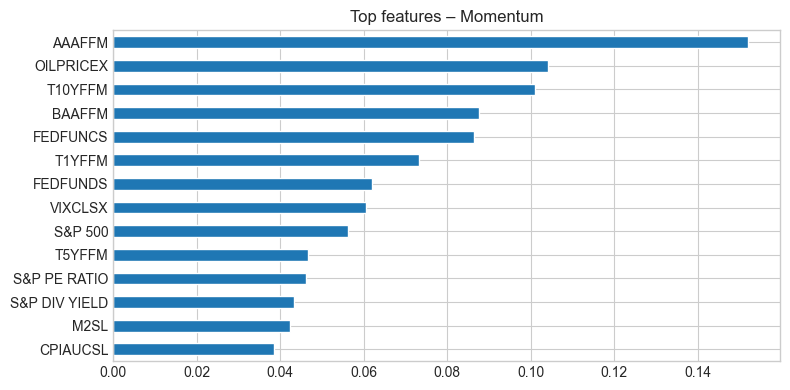


 STRAT : Value

[Value] Best pen λ          : 0.0
[Value] Best threshold      : 0.5
[Value] Best Sharpe (VALID): 0.4996321564119424
[Value] Sharpe TEST : 1.0180083089687706

[Feature importance – Value]
AAAFFM           0.153525
BAAFFM           0.080056
T5YFFM           0.079314
S&P 500          0.079281
FEDFUNCS         0.078556
T10YFFM          0.068805
T1YFFM           0.068601
OILPRICEX        0.068236
CPIAUCSL         0.056962
FEDFUNDS         0.056796
S&P PE RATIO     0.054865
VIXCLSX          0.053704
S&P DIV YIELD    0.051338
M2SL             0.049959
dtype: float32


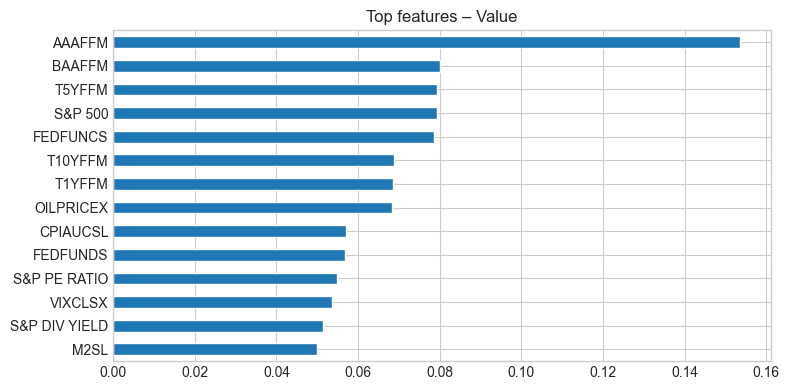


 STRAT : Size

[Size] Best pen λ          : 0.0
[Size] Best threshold      : 0.6
[Size] Best Sharpe (VALID): 0.4669679620045507
[Size] Sharpe TEST : 0.896052606846004

[Feature importance – Size]
T5YFFM           0.104632
AAAFFM           0.098643
FEDFUNCS         0.096401
BAAFFM           0.095109
S&P 500          0.079343
S&P DIV YIELD    0.079002
T1YFFM           0.073200
T10YFFM          0.063069
CPIAUCSL         0.058377
OILPRICEX        0.056107
VIXCLSX          0.055333
S&P PE RATIO     0.053851
FEDFUNDS         0.045406
M2SL             0.041528
dtype: float32


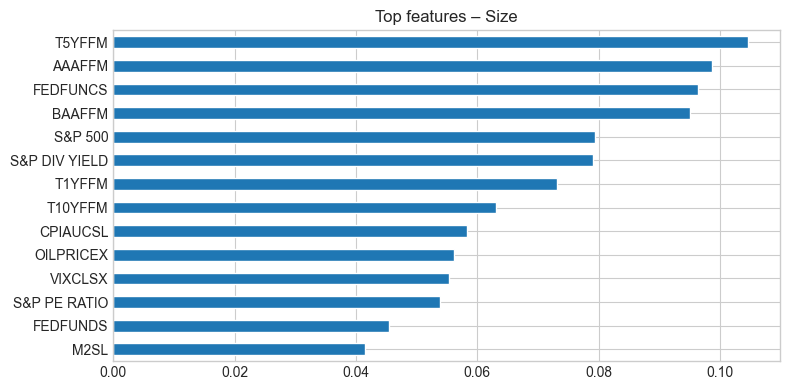


=== Paramètres retenus pour chaque stratégie ===

          best_pen  best_threshold  best_sharpe start_train   end_train  \
name                                                                      
Momentum      0.02             0.4     0.428806  1963-01-01  2000-01-01   
Value         0.00             0.5     0.499632  1963-01-01  2000-01-01   
Size          0.00             0.6     0.466968  1963-01-01  2000-01-01   

             end_val  cost_bps  max_depth  n_estimators  learning_rate  \
name                                                                     
Momentum  2015-01-01         5          3           200           0.05   
Value     2015-01-01         5          3           200           0.05   
Size      2015-01-01         5          4           300           0.05   

          subsample  colsample_bytree  
name                                   
Momentum        0.8               0.8  
Value           0.8               0.8  
Size            0.8               0.8  


In [30]:
multi = MultiAFStrategies(strats).run_all()


The feature rankings highlight a clear dominance of credit spreads and the yield-curve structure across all three factor models. These macro-financial variables carry substantially more weight than sentiment or market-level indicators (S&P 500, VIX), although those remain present in the signal mix.
For Momentum, the prominence of AAAFFM and OILPRICEX points to a strong dependence on financial conditions and cyclical dynamics. Value shows a similar configuration, with credit spreads and intermediate maturities driving a large share of the signal, suggesting a fairly broad macro sensitivity. Size displays a comparable hierarchy but places slightly more emphasis on the curve slope (T5YFFM) and aggregate market conditions.
The optimal λ values close to zero indicate weak or loosely defined regime segmentation, and the decision thresholds vary across factors, reflecting a signal structure that is not cleanly separable. The VALID → TEST performance is reasonable, but should be interpreted cautiously given the heavy reliance on the same macro blocks across strategies.

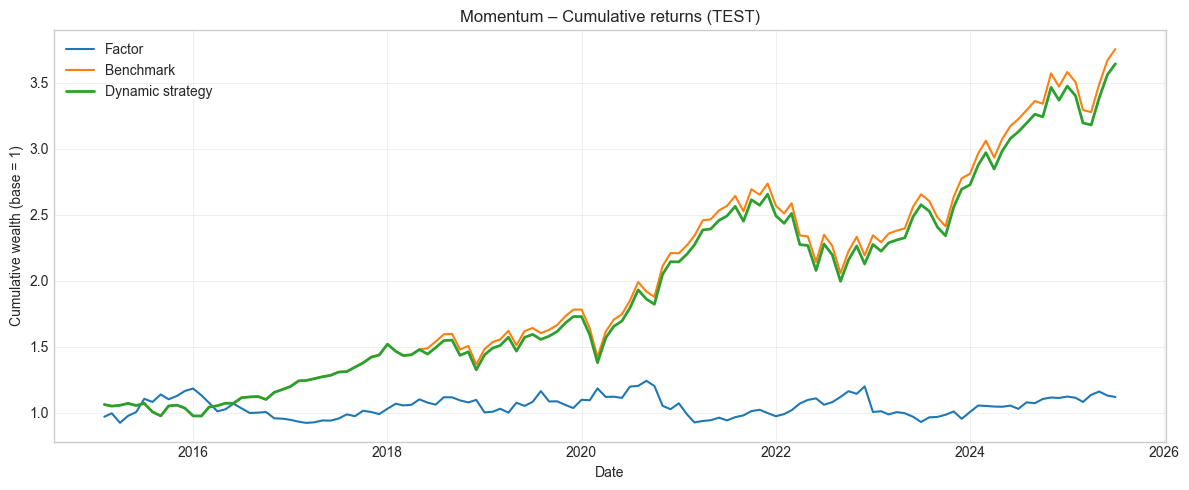

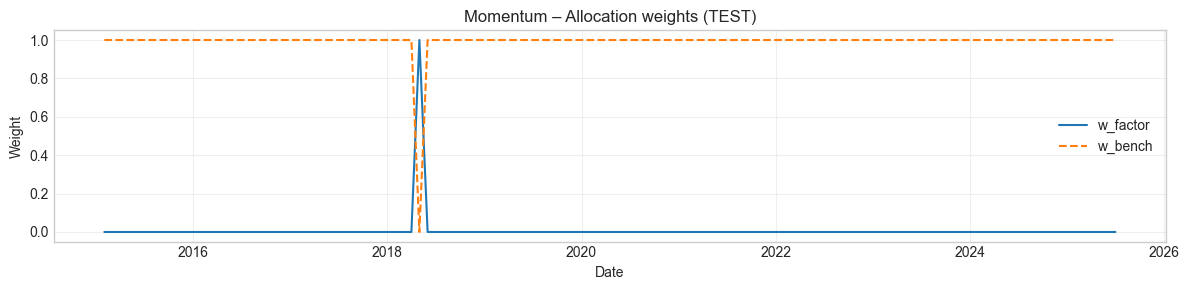

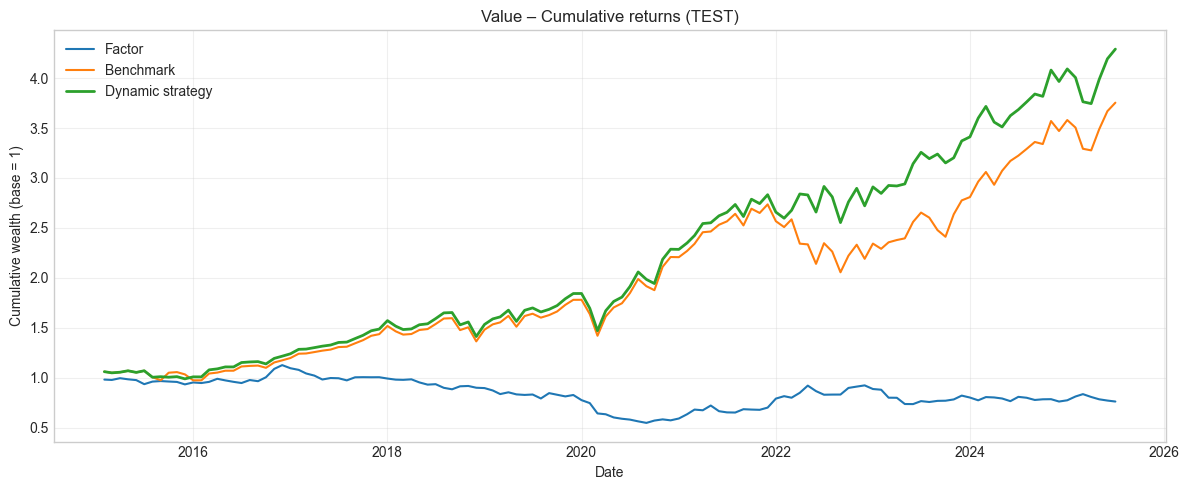

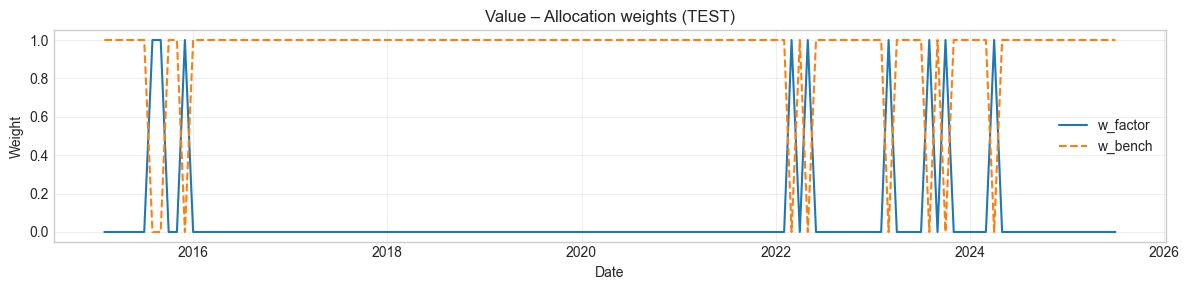

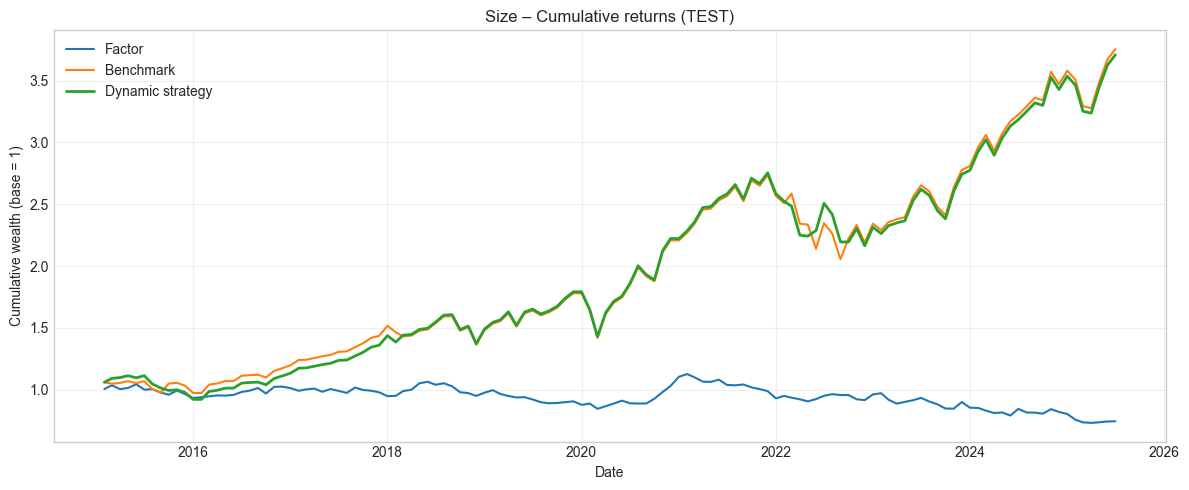

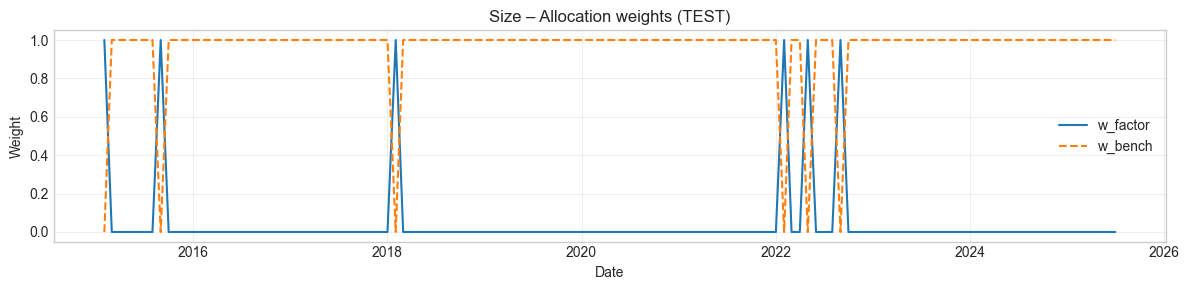

In [31]:
multi.plot_all()

Momentum (TEST)
The cumulative returns show a dynamic allocation that closely tracks the benchmark, with only a brief switch toward the factor around 2018. Outside of that short window, the model allocates almost entirely to the benchmark. The factor itself remains weak throughout the sample, and the strategy’s profile is therefore largely inherited from the benchmark path. The allocation plot confirms a very low number of switches, driven by a stable predicted regime structure.

Value (TEST)
The dynamic strategy diverges more visibly from the benchmark, especially post-2021, reflecting a larger number of allocation flips. The underlying factor stays structurally weak, so improvements mostly come from episodic reallocations. The allocation weights show frequent switching during high-volatility phases, hinting at less stable regime forecasts than for Momentum. Most of the time, however, the model remains benchmark-biased, with the factor position activated only in short bursts.

Size (TEST)
The cumulative return path is again close to the benchmark, with moderate deviations depending on regime changes. The factor stays depressed across the full sample, so the strategy rarely holds it for long. The allocation weights exhibit clustering of switches, especially around 2016 and 2022, followed by long periods of full benchmark exposure. Overall, the system behaves conservatively, engaging the factor only in narrow intervals where the predicted regime briefly turns favorable.


=== Poids Mbj sur les stratégies ===

Momentum    0.000000
Value       0.996853
Size        0.079271
Name: w_mbj, dtype: float64


Momentum    0.000000
Value       0.996853
Size        0.079271
Name: w_mbj, dtype: float64

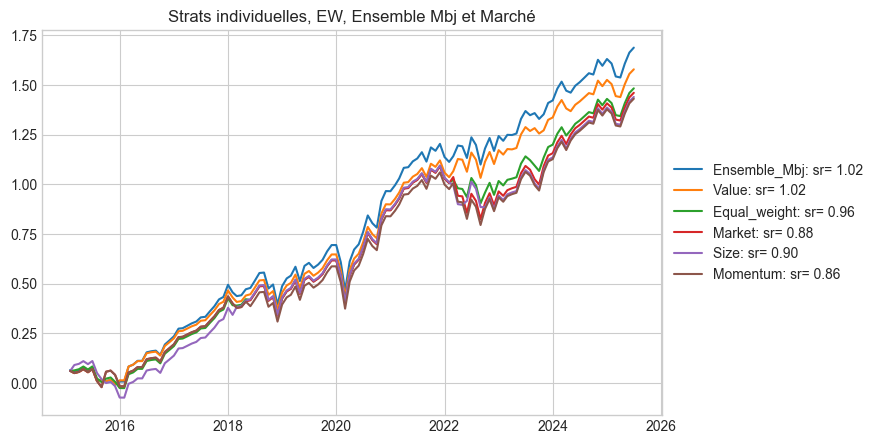

In [32]:
multi.plot_multi()

The combined view shows that most curves move closely together, with differences mainly arising from moderate shifts in drawdowns and recovery speed. Value dominates the ensemble behaviour, which is consistent with the Mbj weights: the optimizer places almost all the allocation on Value, with a small contribution from Size and effectively none from Momentum. This concentration reflects the relative stability of Value’s out-of-sample profile within the test window, while Momentum contributes little due to its weaker and more erratic standalone path. The equal-weight blend tracks the market fairly closely, with only limited dispersion across the individual dynamic strategies.

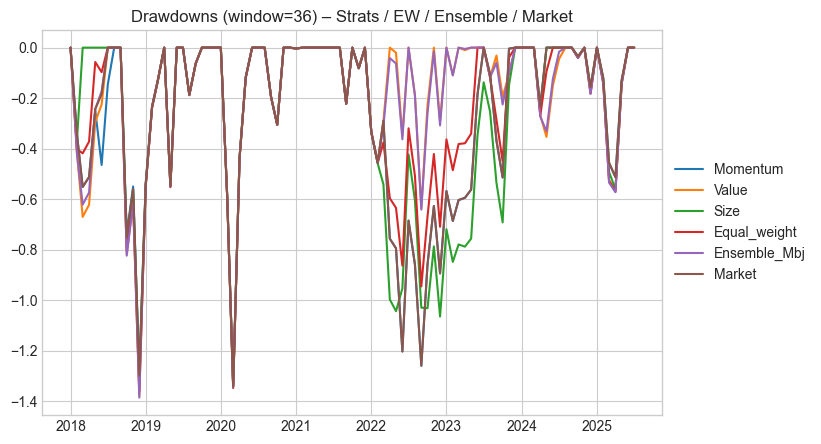

In [33]:
multi.plot_drawdowns(window=36)

The drawdown profiles across strategies remain tightly clustered, with most series following the market’s pattern almost point-for-point. The deepest contractions occur around 2022–2023, where all allocations exhibit similar troughs, and differences between them are relatively small. Size shows slightly larger drawdowns in that segment, while Value and the ensemble remain closer to the benchmark path. Equal-weight and Momentum track the market drawdowns with only minor deviations. Overall, the curves indicate that the allocation shifts affect return levels more than the timing or magnitude of drawdowns, which remain largely shared across strategies.

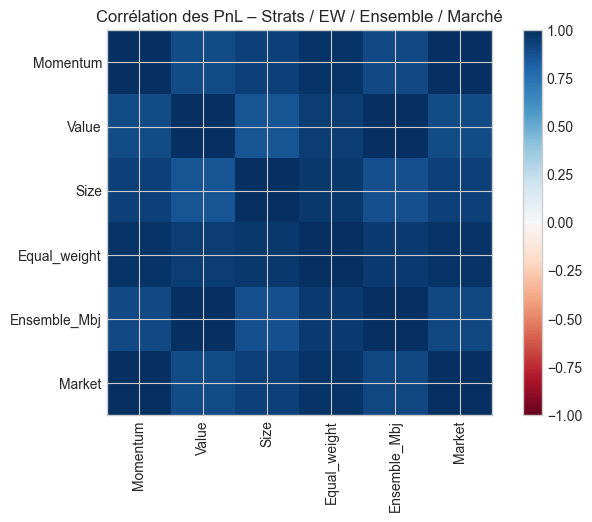

In [34]:
corr = multi.plot_corr_heatmap()

The correlation matrix shows that all strategies exhibit broadly similar return patterns, with values clustering in the same range across pairs. The three individual factor strategies remain moderately correlated with each other and with the benchmark, with no clear low-correlation outlier. Equal-weight and the Mbj ensemble naturally sit close to the market as well, reflecting their construction. Overall, the matrix indicates limited diversification between the components: most series move in tandem and share a common underlying market structure.